# Forecast lost object on train stations 

The aim of this project is to forecast lost object from Paris SNCF stations using time series prediction, the study was done in 2018.

Technical report could be found [here](https://docs.google.com/presentation/d/1H58gBLj_xadYaVtUGKRI2wh9h7VlnW5jYEs1VSigMCs)

Note : This notebook needs some serious rework.

### Install dependencies

In [31]:
install.packages('ggplot2')
install.packages('dplyr')
install.packages('lubridate')
install.packages('tstools')
install.packages('nnfor')

Warning message:
"package 'ggplot2' is in use and will not be installed"Warning message:
"package 'dplyr' is in use and will not be installed"Warning message:
"package 'lubridate' is in use and will not be installed"Warning message:
"package 'tstools' is in use and will not be installed"also installing the dependencies 'RcppParallel', 'lamW', 'pracma', 'statmod', 'TTR', 'curl', 'greybox', 'nloptr', 'quadprog', 'quantmod', 'codetools', 'iterators', 'smooth', 'fracdiff', 'lmtest', 'nnet', 'timeDate', 'tseries', 'urca', 'RcppArmadillo', 'foreach', 'shape', 'Deriv', 'MAPA', 'forecast', 'glmnet', 'neuralnet', 'plotrix', 'tsutils', 'uroot'




  There is a binary version available but the source version is later:
             binary source needs_compilation
RcppParallel  5.0.0  5.0.1              TRUE

  Binaries will be installed
package 'RcppParallel' successfully unpacked and MD5 sums checked
package 'lamW' successfully unpacked and MD5 sums checked
package 'pracma' successfully unpacked and MD5 sums checked
package 'statmod' successfully unpacked and MD5 sums checked
package 'TTR' successfully unpacked and MD5 sums checked
package 'curl' successfully unpacked and MD5 sums checked
package 'greybox' successfully unpacked and MD5 sums checked
package 'nloptr' successfully unpacked and MD5 sums checked
package 'quadprog' successfully unpacked and MD5 sums checked
package 'quantmod' successfully unpacked and MD5 sums checked
package 'codetools' successfully unpacked and MD5 sums checked
package 'iterators' successfully unpacked and MD5 sums checked
package 'smooth' successfully unpacked and MD5 sums checked
package 'fracdiff

### Load dependencies 

In [33]:
library(ggplot2)
library(dplyr)
library(lubridate)
library(tstools)
library(nnfor)

Loading required package: forecast
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


### Processing and visualising data

In [2]:
options(stringsAsFactors = FALSE)
# Downloading and reading a large file : This may take time 
objets_trouvees <- read.csv2("https://www.data.gouv.fr/fr/datasets/r/49f5bbda-6e2e-42bd-b8fc-a71417fe10fc"
                ,fileEncoding="UTF-8"
                ,header = TRUE)

str(objets_trouvees)
summary(objets_trouvees)

'data.frame':	664870 obs. of  7 variables:
 $ Date                        : chr  "2014-03-09T14:25:29+01:00" "2018-01-23T15:07:32+01:00" "2018-02-06T15:35:49+01:00" "2014-03-10T09:07:15+01:00" ...
 $ Date.et.heure.de.restitution: chr  "" "" "" "" ...
 $ Gare                        : chr  "Paris Montparnasse" "Saint-Étienne Châteaucreux" "Rennes" "Toulouse Matabiau" ...
 $ Code.UIC                    : int  87391003 87726000 87471003 87611004 87223263 87113001 87741009 87722025 87391003 87212027 ...
 $ Nature.d.objets             : chr  "Manteau, veste, blazer, parka, blouson, cape" "Montre" "Clés, porte-clés" "Sac de voyage, sac de sport, sac à bandoulière" ...
 $ Type.d.objets               : chr  "Vêtements, chaussures" "Bijoux, montres" "Clés, porte-clés, badge magnétique" "Bagagerie: sacs, valises, cartables" ...
 $ Type.d.enregistrement       : chr  "Objet trouvé" "Objet trouvé" "Objet trouvé" "Objet trouvé" ...


     Date           Date.et.heure.de.restitution     Gare          
 Length:664870      Length:664870                Length:664870     
 Class :character   Class :character             Class :character  
 Mode  :character   Mode  :character             Mode  :character  
                                                                   
                                                                   
                                                                   
                                                                   
    Code.UIC        Nature.d.objets    Type.d.objets      Type.d.enregistrement
 Min.   :87111849   Length:664870      Length:664870      Length:664870        
 1st Qu.:87286542   Class :character   Class :character   Class :character     
 Median :87474098   Mode  :character   Mode  :character   Mode  :character     
 Mean   :87482464                                                              
 3rd Qu.:87686006                                       

In [4]:
objets_trouvees$Date = as.Date(objets_trouvees$Date, "%Y-%m-%d")
objets_trouvees_table = table(objets_trouvees$Date,objets_trouvees$Type.d.objets,objets_trouvees$Gare)
objets_trouvees_table = data.frame(objets_trouvees_table,stringsAsFactors = FALSE)
names(objets_trouvees_table) = c("Date", "Type", "Gare","Objets") # TODO : to DNN
objets_trouvees_table$Date = as.Date(objets_trouvees_table$Date)

Warning message in `==.default`(objets_trouvees_table$Gare, gare):
"la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court"Warning message in is.na(e1) | is.na(e2):
"la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court"

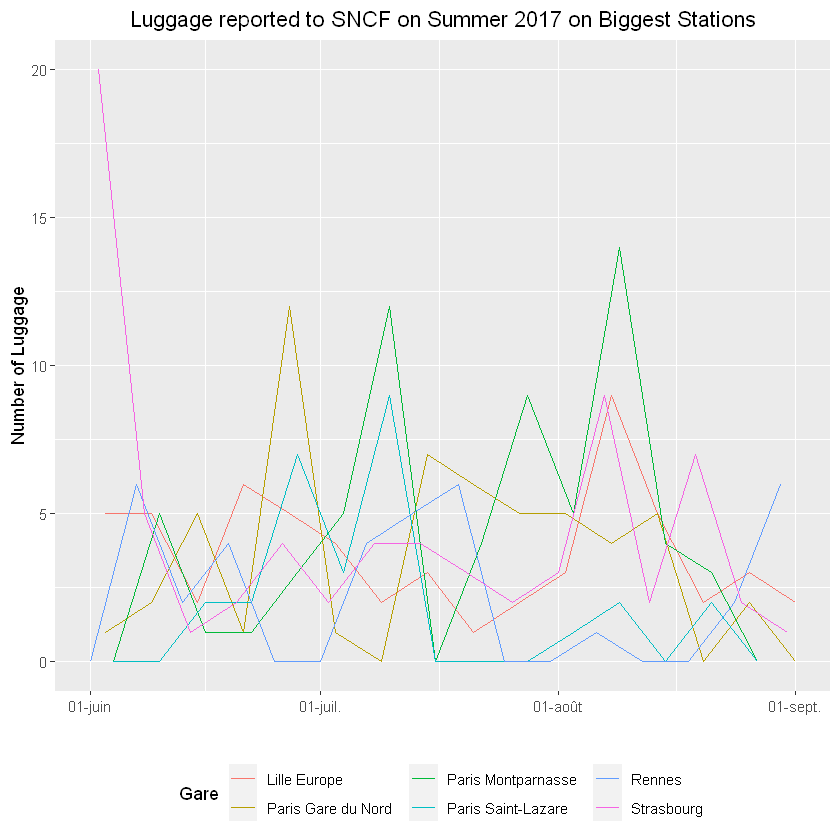

In [5]:
#Filtred value
selectedGare = order(table(objets_trouvees$Gare), decreasing = TRUE ) [2:7]
gare=data.frame(table(objets_trouvees$Gare) , stringsAsFactors = FALSE)[selectedGare,]$Var1 
type="Bagagerie: sacs, valises, cartables"

objets_trouvees_table_selected = objets_trouvees_table[which(objets_trouvees_table$Date >= "2017-06-01" 
                                                             & objets_trouvees_table$Date <= "2017-09-01"
                                                             & objets_trouvees_table$Gare == gare 
                                                             & objets_trouvees_table$Type == type
                                                             )
                                                              , ]

ggplot(objets_trouvees_table_selected, aes(x = Date, y = Objets, color=Gare)) +
  geom_line() + 
  scale_x_date(date_labels = "%d-%b") + 
  xlab("") + 
  ylab("Number of Luggage") + 
  #facet_grid(Gare~Type)
  ggtitle("Luggage reported to SNCF on Summer 2017 on Biggest Stations") +
  theme(plot.title = element_text(hjust = 0.5)) +
  theme(legend.position="bottom")


NULL

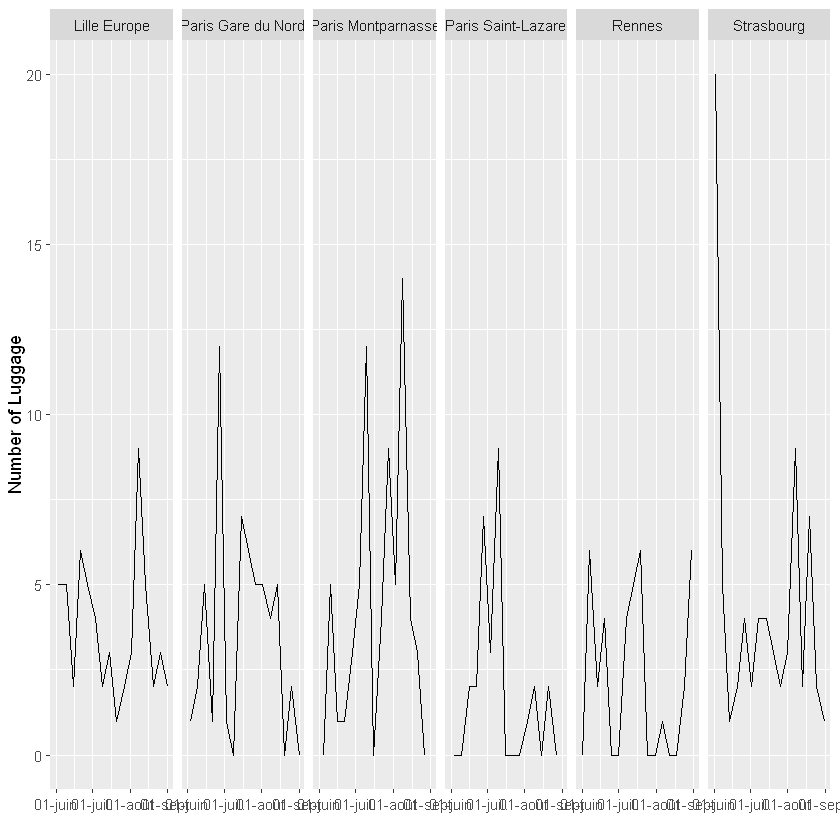

In [6]:

ggplot(objets_trouvees_table_selected, aes(x = Date, y = Objets)) +
  geom_line() + 
  scale_x_date(date_labels = "%d-%b") + 
  xlab("") + 
  ylab("Number of Luggage") + 
  facet_grid(~Gare)
  ggtitle("Luggage reported to SNCF on Summer 2017 on Biggest Stations") +
  theme(plot.title = element_text(hjust = 0.5))

Warning message in `==.default`(objets_trouvees_table$Type, type):
"la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court"Warning message in is.na(e1) | is.na(e2):
"la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court"

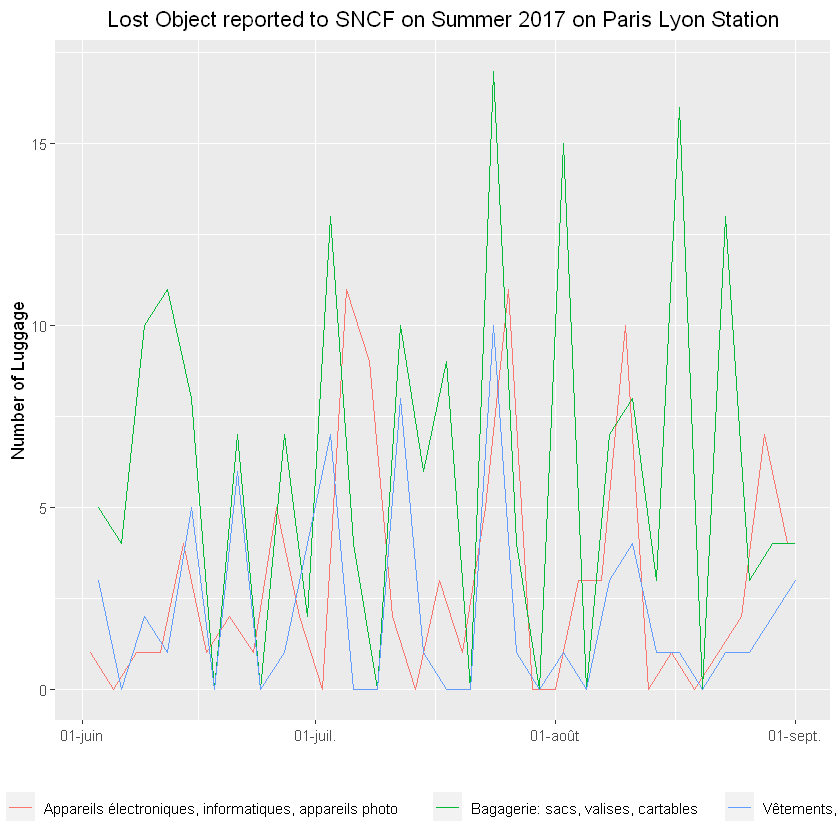

In [8]:
  
  # fixed one station
  
  #FIltred value

  
  selectedType = order(table(objets_trouvees$Type.d.objets), decreasing = TRUE ) [1:3]
  type=data.frame(table(objets_trouvees$Type.d.objets) , stringsAsFactors = FALSE)[selectedType,]$Var1 
  gare="Paris Gare de Lyon"

  objets_trouvees_table_selected2 = objets_trouvees_table[which(objets_trouvees_table$Date >= "2017-06-01" 
                                                               & objets_trouvees_table$Date <= "2017-09-01"
                                                               & objets_trouvees_table$Gare == gare 
                                                               & objets_trouvees_table$Type == type
  )
  , ]
  
  ggplot(objets_trouvees_table_selected2, aes(x = Date, y = Objets, color=Type)) +
    geom_line() + 
    scale_x_date(date_labels = "%d-%b") + 
    xlab("") + 
    ylab("Number of Luggage") + 
    #facet_grid(Gare~Type)
    ggtitle("Lost Object reported to SNCF on Summer 2017 on Paris Lyon Station") +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(legend.position="bottom")
  

 

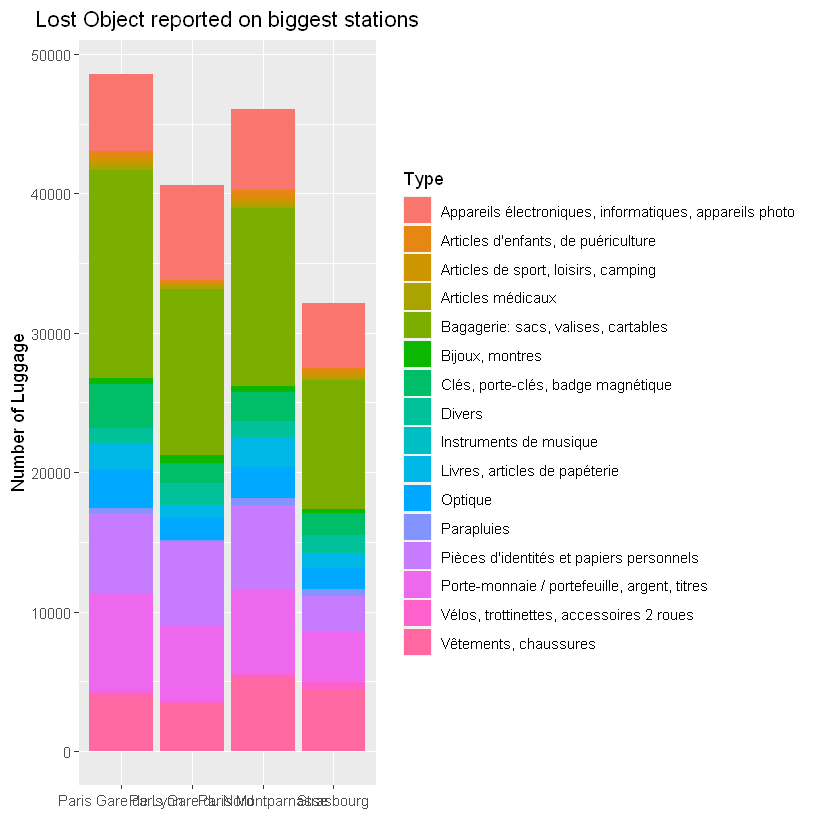

In [13]:
 # for all date
  
  objets_trouvees_table2 = table(objets_trouvees$Type.d.objets,objets_trouvees$Gare)
  objets_trouvees_table2 = data.frame(objets_trouvees_table2,stringsAsFactors = FALSE)
  names(objets_trouvees_table2) = c("Type", "Gare","Objets") # TODO : to DNN
   
  #FIltred value
  selectedType = order(table(objets_trouvees$Type.d.objets), decreasing = TRUE ) [1:5]
  type=data.frame(table(objets_trouvees$Type.d.objets) , stringsAsFactors = FALSE)[selectedType,]$Var1 
  
  
  objets_trouvees_table_selected2 = objets_trouvees_table2[which(objets_trouvees_table2$Gare == "Paris Gare de Lyon"
                                                                 | objets_trouvees_table2$Gare == "Paris Gare du Nord"
                                                                | objets_trouvees_table2$Gare == "Paris Montparnasse"
                                                           | objets_trouvees_table2$Gare == "Strasbourg"), ]

  
  ggplot(objets_trouvees_table_selected2, aes(x = Gare, y = Objets, fill=Type)) +
    geom_bar(stat="identity") + 
    #scale_x_date(date_labels = "%d-%b") + 
    xlab("") + 
    ylab("Number of Luggage") + 
    #facet_grid(Gare~Type)
    ggtitle("Lost Object reported on biggest stations") +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(legend.position="right")
  
  
  


In [14]:
frequentation <- read.csv2("https://www.data.gouv.fr/fr/datasets/r/d4cf16d5-dd91-453c-887e-6084639caac8"
                                 ,fileEncoding="UTF-8"
                                 ,header = TRUE)

In [20]:
summary(frequentation)

 Nom.de.la.gare     Code.UIC.complet    Code.postal    Segmentation.DRG.2018
 Length:3015        Min.   :87000028   Min.   : 1000   Length:3015          
 Class :character   1st Qu.:87313118   1st Qu.:31795   Class :character     
 Mode  :character   Median :87486423   Median :58320   Mode  :character     
                    Mean   :87488091   Mean   :53011                        
                    3rd Qu.:87683590   3rd Qu.:74385                        
                    Max.   :87988717   Max.   :98000                        
 Total.Voyageurs.2018 Total.Voyageurs...Non.voyageurs.2018 Total.Voyageurs.2017
 Min.   :        0    Min.   :        0                    Min.   :        0   
 1st Qu.:     6769    1st Qu.:     6769                    1st Qu.:     7496   
 Median :    40228    Median :    40228                    Median :    43305   
 Mean   :   899957    Mean   :   996567                    Mean   :   915421   
 3rd Qu.:   219762    3rd Qu.:   266110                    3r

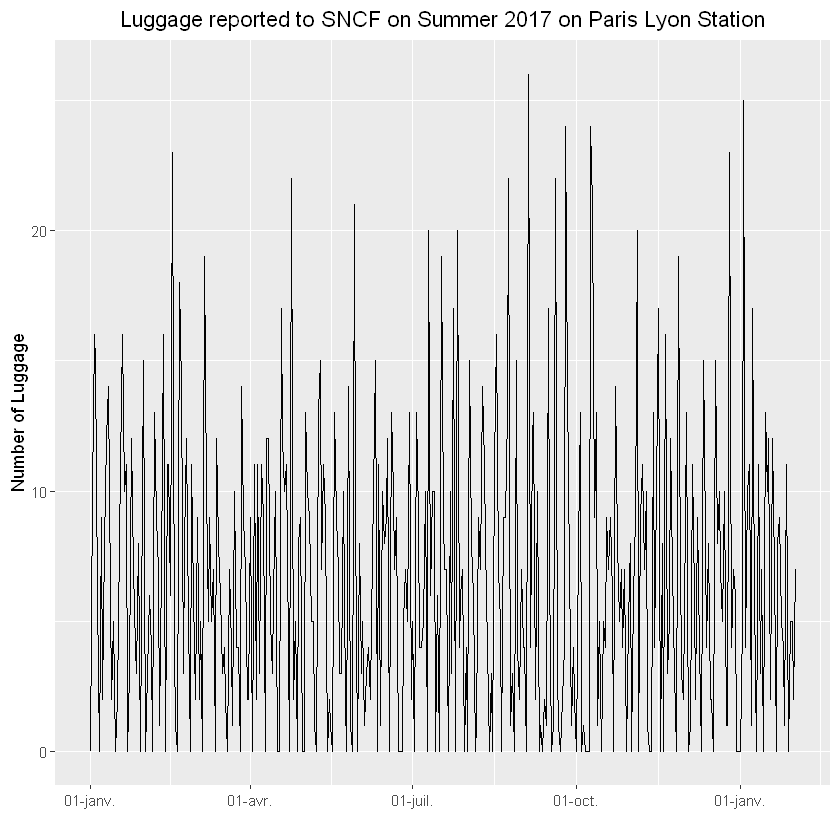

In [25]:

# FIXME : this code regressed after update of the dataset

#   ggplot(frequentation, aes(x = Gare, y = Objets, fill=Type)) +
#     geom_bar(stat="identity") + 
#     #scale_x_date(date_labels = "%d-%b") + 
#     xlab("") + 
#     ylab("Number of Luggage") + 
#     #facet_grid(Gare~Type)
#     ggtitle("Lost Object reported on biggest stations") +
#     theme(plot.title = element_text(hjust = 0.5)) +
#     theme(legend.position="right") 
    
objets_par_gare=data.frame(table(objets_trouvees$Gare))
names(objets_par_gare)=c('Gare',"Objets perdues")
frequentation_2016_par_gare=frequentation[,c("Nom.de.la.gare","Total.Voyageurs.2016")]
names(frequentation_2016_par_gare)=c('Gare','Voyageurs 2016')
merge_freq_objets=merge(frequentation_2016_par_gare,objets_par_gare,by="Gare")
merge_freq_objets$Rate = 1000 * merge_freq_objets$`Objets perdues` / merge_freq_objets$`Voyageurs 2016`


type3="Bagagerie: sacs, valises, cartables" 
gare3="Paris Gare de Lyon"

objets_trouvees_table_selected3 = objets_trouvees_table[which(objets_trouvees_table$Date >= "2017-01-01" 
                                                              & objets_trouvees_table$Date <= "2018-02-01"
                                                              & objets_trouvees_table$Gare == gare3 
                                                              & objets_trouvees_table$Type == type3
)
, ]

objets_trouvees_table_selected3=objets_trouvees_table_selected3[,c('Date','Objets')]

ggplot(objets_trouvees_table_selected3, aes(x = Date, y = Objets)) +
  geom_line() + 
  scale_x_date(date_labels = "%d-%b") + 
  xlab("") + 
  ylab("Number of Luggage") + 
  #facet_grid(Gare~Type)
  ggtitle("Luggage reported to SNCF on Summer 2017 on Paris Lyon Station") +
  theme(plot.title = element_text(hjust = 0.5)) +
  theme(legend.position="bottom")

### Predict lost object 

In [38]:
tsSNCF=objets_trouvees_table_selected3
startTs=min(tsSNCF$Date)
tsSNCFts = ts(tsSNCF$Objets, start=c(2017,1), frequency = 365)

In [36]:
tsSNCF.fit=mlp(tsSNCFts)
# tsSNCF.fit=mlp(tsSNCFts,hd.auto.type="valid",hd.max=20)
plot(tsSNCF.fit)

Warning message in preprocess(y, m, lags, keep, difforder, sel.lag, allow.det.season, :
"No inputs left in the network after pre-selection, forcing AR(1)."

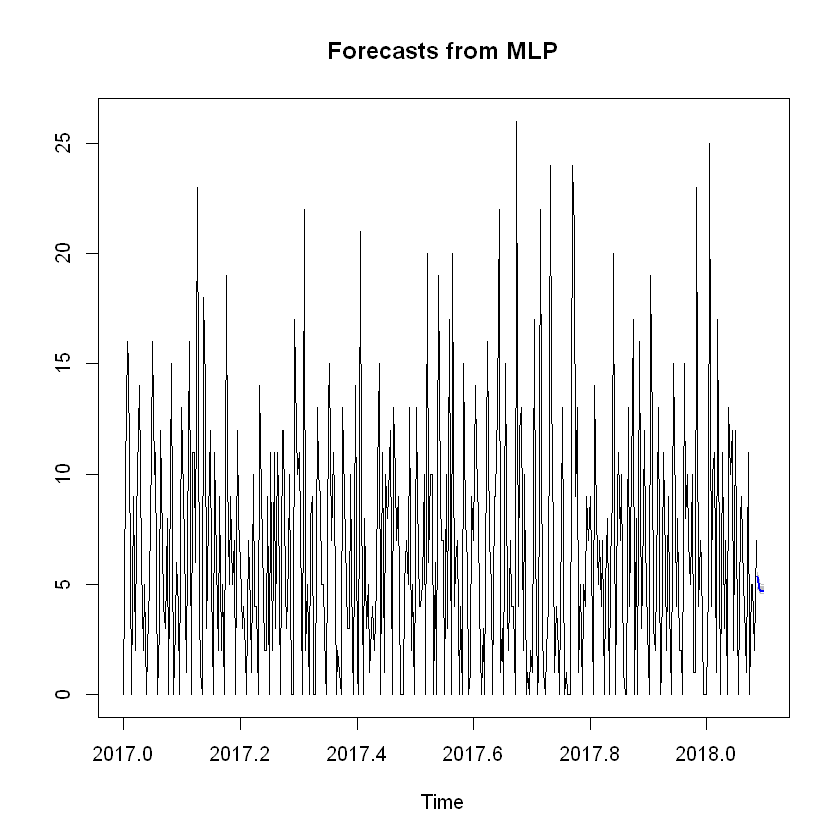

In [39]:
tsSNCF.frc = forecast(tsSNCF.fit,h=5)
plot(tsSNCF.frc)